In [194]:
import os
import glob

from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import cv2
import os
import ast
import albumentations as A
from tqdm import tqdm

## Show example data

In [220]:
test_file_name = 'S8_jpg.rf.a6fc375e5671f87b32ca0d691750a310'
test_img_path = f'./data/ASLv1/yolo11/train/images/{test_file_name}.jpg'
test_label_path = f'./data/ASLv1/yolo11/train/labels/{test_file_name}.txt'

test_image = cv2.imread(test_img_path)

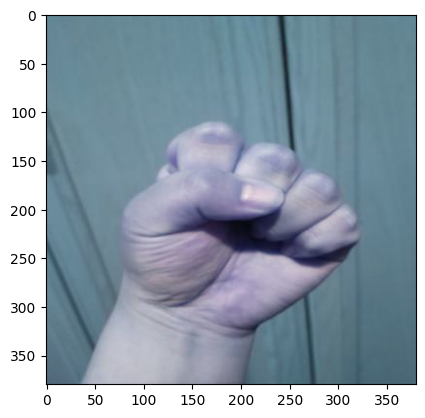

In [221]:
plt.imshow(test_image)

In [222]:
test_image.shape

(380, 380, 3)

This is the bounding box

In [223]:
load_bboxes = np.genfromtxt(test_label_path)
load_bboxes = list(load_bboxes)
bbox_cat = int(load_bboxes[0])
bboxes = load_bboxes[1:]
bboxes

[0.5210829412207955,
 0.5634557853687923,
 0.7583467382048525,
 0.6419927327358257]

This is the label

In [224]:
bbox_cat

18

In [225]:
# Image info
img_ht = int(test_image.shape[0])
img_wd = int(test_image.shape[1])
bb_width = int(round(bboxes[2] * test_image.shape[1], 0))
bb_height = int(round(bboxes[3] * test_image.shape[0], 0))

print(f'test_image height: {img_ht}')
print(f'Image width: {img_wd}')
print(f'Bbox height: {bb_height}')
print(f'Bbox width: {bb_width}')

test_image height: 380
Image width: 380
Bbox height: 244
Bbox width: 288


In [226]:
# pascal_voc format
x_min = int((img_wd * bboxes[0]) - (bb_width / 2))
x_max = int((img_wd * bboxes[0]) + (bb_width / 2))
y_min = int(img_ht * bboxes[1] - (bb_height / 2))
y_max = int(img_ht * bboxes[1] + (bb_height / 2))
new_bboxes = [x_min, y_min, x_max, y_max]
print(f'Bbox x_min: {x_min}')
print(f'Bbox x_max: {x_max}')
print(f'Bbox y_min: {y_min}')
print(f'Bbox y_max: {y_max}')
print(f'new_bboxes: {new_bboxes}')

Bbox x_min: 54
Bbox x_max: 342
Bbox y_min: 92
Bbox y_max: 336
new_bboxes: [54, 92, 342, 336]


## Show image and Bounding Box Function

In [227]:
category_id_to_name = {
    0: 'A',
    1: 'B',
    2: 'C',
    3: 'D',
    4: 'E',
    5: 'F',
    6: 'G',
    7: 'H',
    8: 'I',
    9: 'J',
    10: 'K',
    11: 'L',
    12: 'M',
    13: 'N',
    14: 'O',
    15: 'P',
    16: 'Q',
    17: 'R',
    18: 'S',
    19: 'T',
    20: 'U',
    21: 'V',
    22: 'W',
    23: 'X',
    24: 'Y',
    25: 'Z',
}
BOX_COLOR = (255, 0, 0)
TEXT_COLOR = (255, 255, 255)  # White


def visualize_bbox(image, bbox, class_name, color=BOX_COLOR, thickness=4):
    x_min, y_min, x_max, y_max = map(lambda v: int(v), bbox)

    cv2.rectangle(image, (x_min, y_min), (x_max, y_max),
                  color=color,
                  thickness=thickness)

    ((text_width, text_height), _) = cv2.getTextSize(class_name,
                                                     cv2.FONT_HERSHEY_SIMPLEX,
                                                     2.7, 3)
    cv2.rectangle(image, (x_min, y_min - int(1.2 * text_height)),
                  (x_min + text_width, y_min), BOX_COLOR, -1)
    cv2.putText(
        image,
        text=category_id_to_name[bbox_cat],
        org=(x_min, y_min - int(.1 * text_height)),
        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
        fontScale=2.35,
        color=TEXT_COLOR,
        thickness=3,
        lineType=cv2.LINE_AA,
    )
    return image


def show_image(image, bbox, bbox_cat, category_id_to_name):
    class_name = category_id_to_name[bbox_cat]
    image = visualize_bbox(image.copy(), bbox, class_name)
    f = plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), interpolation='nearest')
    plt.axis('off')
    f.tight_layout()
    plt.show()

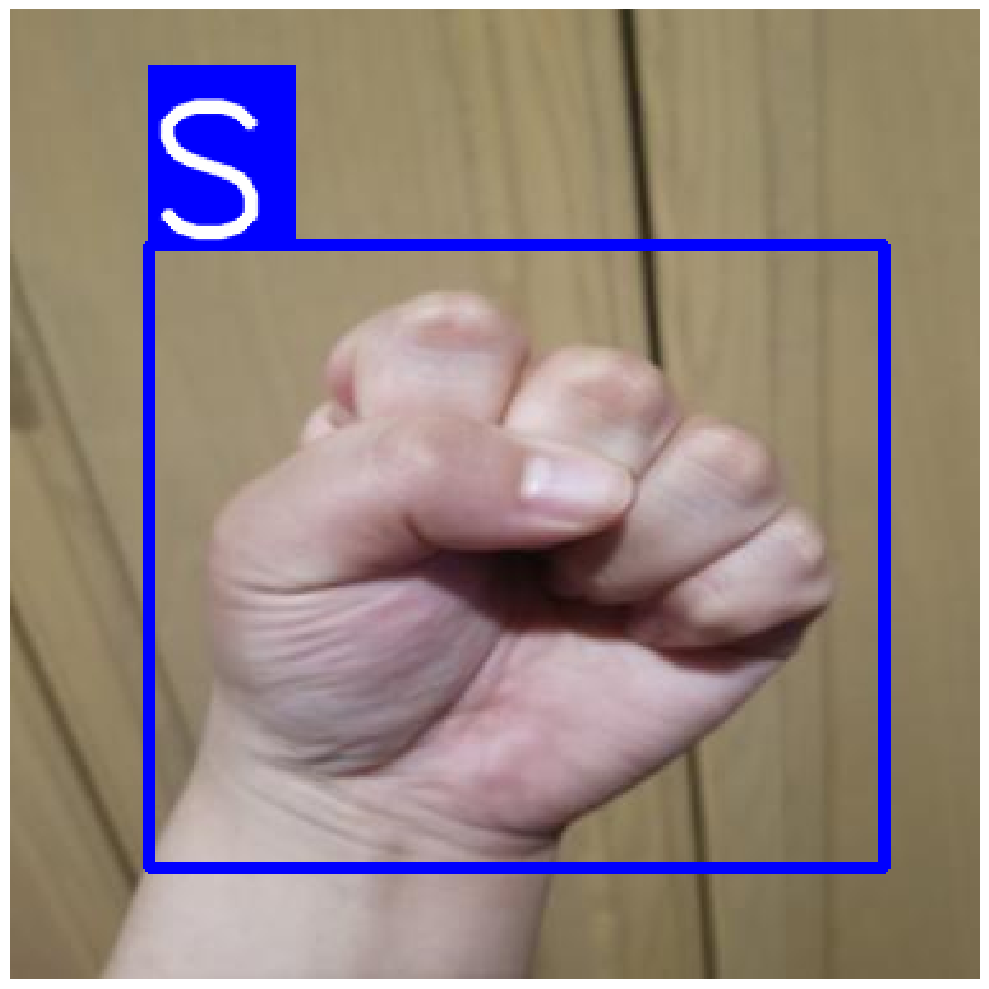

In [228]:
show_image(test_image, new_bboxes, bbox_cat, category_id_to_name)

## Augment Data

In [229]:
def show_augmented(augmentation, image, bbox, class_name):
    augmented = augmentation(image=image,
                             bboxes=[bbox],
                             class_name=[class_name])
    show_image(augmented['image'], augmented['bboxes'][0], bbox_cat,
               category_id_to_name)

In [230]:
# [x_min, y_min, x_max, y_max]
bbox_params = A.BboxParams(format='pascal_voc',
                           min_area=1,
                           min_visibility=0.5,
                           label_fields=['class_name'])

In [237]:
aug = A.Compose(
    [
        A.LongestMaxSize(max_size=384),
        # A.PadIfNeeded(min_height=1024, min_width=1024, border_mode=0, p=1.0),
        A.PadIfNeeded(min_height=384, min_width=384, p=1.0),
        A.ShiftScaleRotate(shift_limit=.1, scale_limit=0.1, p=0.3),
        A.RandomSizedCrop((300, 300), 384, 384, p=.2),
        A.HorizontalFlip(p=.5),
        A.Rotate(limit=30, p=.8),
        A.MultiplicativeNoise(p=.2),
        A.RGBShift(r_shift_limit=40, g_shift_limit=40, b_shift_limit=40, p=.3),
        A.Blur(blur_limit=3, p=.2),
        A.RandomBrightnessContrast(
            brightness_limit=0.3, contrast_limit=0.35, p=.5),
        A.HueSaturationValue(p=.3),
        A.CoarseDropout(max_holes=6,
                        min_width=15,
                        max_width=15,
                        min_height=20,
                        max_height=20,
                        p=.2),
        A.OneOf([A.GaussNoise(var_limit=(10, 30), mean=50)], p=0.2),
        A.OneOf([
            A.MotionBlur(blur_limit=3, p=0.2),
            A.MedianBlur(blur_limit=3, p=0.1),
            A.Blur(blur_limit=3, p=0.1)
        ],
                p=0.2),
        A.OneOf([
            A.Sharpen(),
            A.Emboss(),
            A.RandomBrightnessContrast(),
            A.RandomGamma(gamma_limit=[80, 120], p=.2),
            A.ToGray()
        ],
                p=0.3),
        A.NoOp(p=.04)
    ],
    bbox_params=bbox_params)

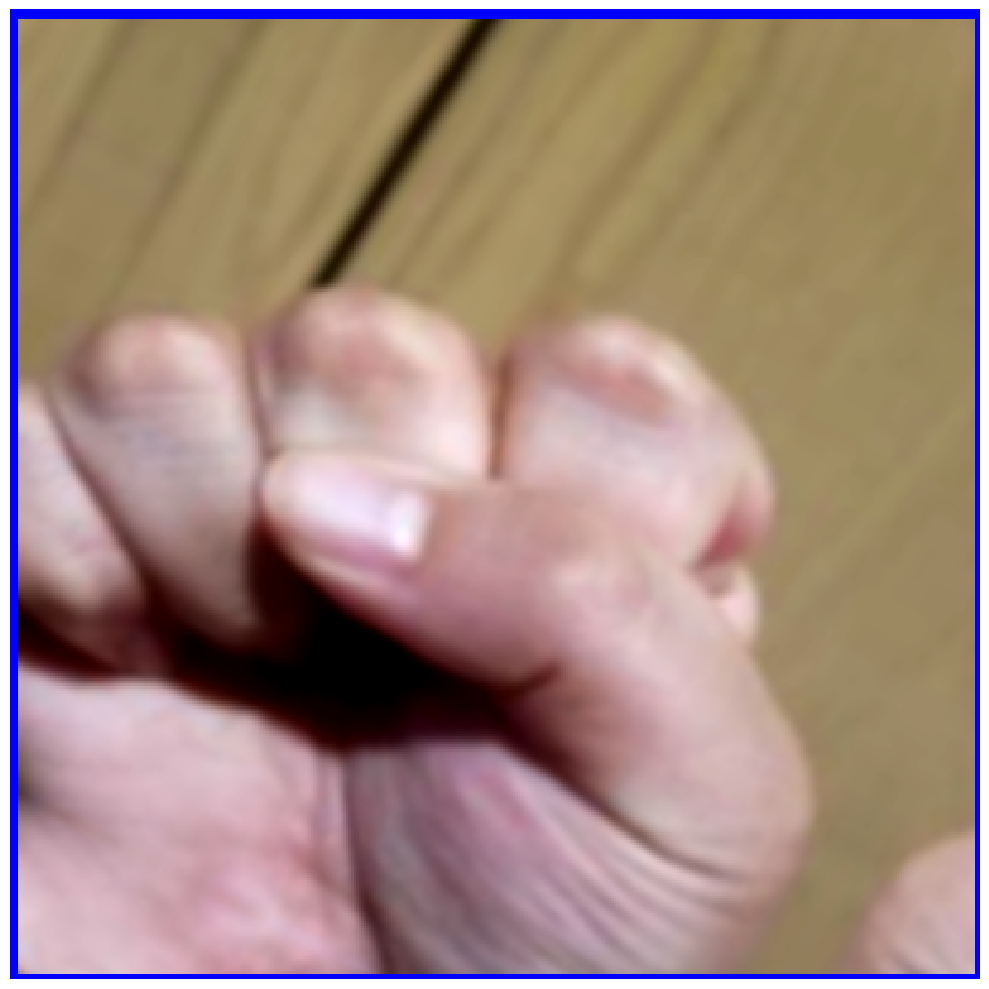

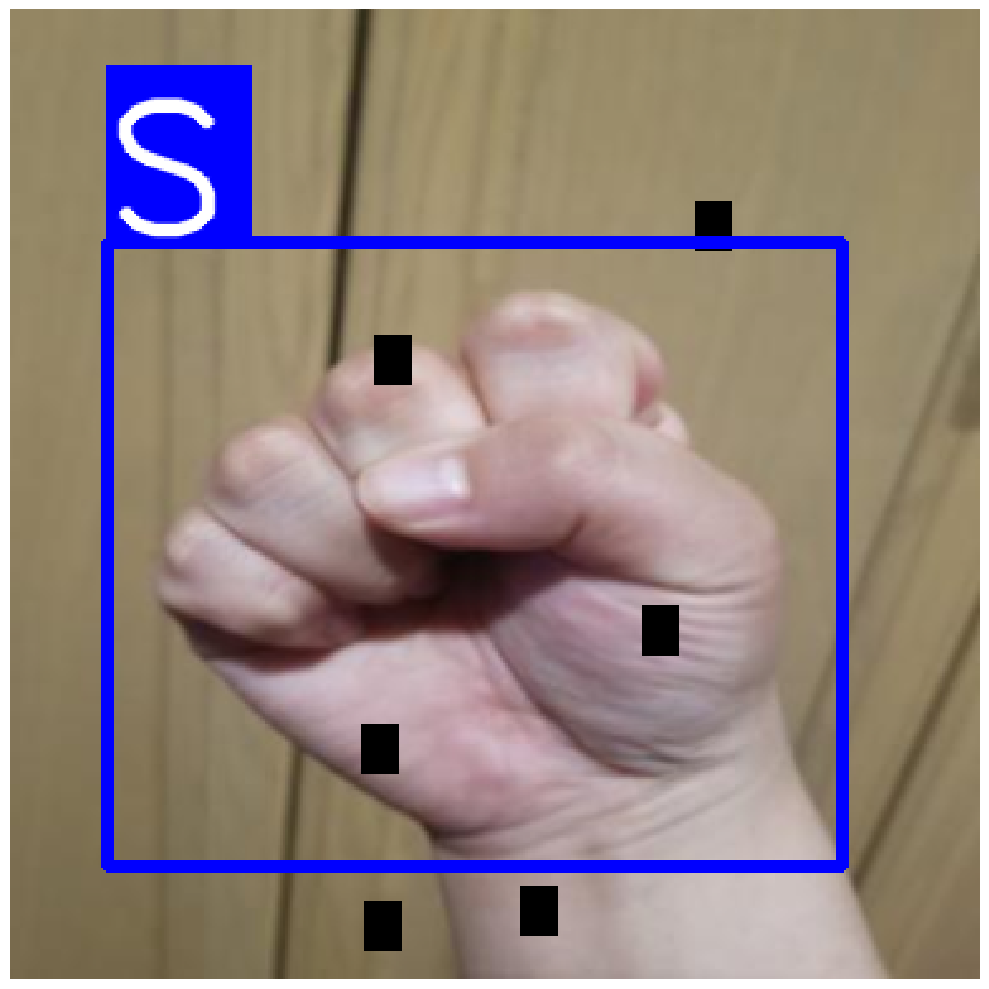

In [232]:
for i in range(2):
    show_augmented(aug, test_image, new_bboxes, bbox_cat)

## Creating Augmented Dataset


In [250]:
def delete_augmented_images(directory):
    # Construct the pattern to match the files
    pattern = os.path.join(directory, '*_aug_*.jpg')

    # Find all files matching the pattern
    files_to_delete = glob.glob(pattern)

    # Delete each file found
    for file_path in files_to_delete:
        try:
            os.remove(file_path)
            # print(f'Deleted: {file_path}')
        except Exception as e:
            print(f'Error deleting {file_path}: {e}')

In [251]:
delete_augmented_images('./data/ASLv1/yolo11/train/images/')

In [262]:
# path_labels = './asl_original_data/labels/'
path_labels = './data/ASLv1/yolo11/train/labels/'
DATASET_PATH = './data/ASLv1/yolo11/train'
IMAGES_PATH = f'{DATASET_PATH}/images'
AUG_IMAGES_PATH = f'{DATASET_PATH}/aug_images'
os.makedirs(DATASET_PATH, exist_ok=True)
os.makedirs(IMAGES_PATH, exist_ok=True)

rows = []

for count, filename in enumerate(os.listdir(IMAGES_PATH)):
    image = cv2.imread(f'{IMAGES_PATH}/{filename}')
    load_bboxes = np.genfromtxt(path_labels + filename[:-4] + '.txt')
    load_bboxes = list(load_bboxes)
    bbox_cat = int(load_bboxes[0])
    bboxes = load_bboxes[1:]
    img_ht = int(image.shape[0])
    img_wd = int(image.shape[1])
    bb_width = int(round(bboxes[2] * image.shape[1], 0))
    bb_height = int(round(bboxes[3] * image.shape[0], 0))

    x_min = int((img_wd * bboxes[0]) - (bb_width / 2))
    x_max = int((img_wd * bboxes[0]) + (bb_width / 2))
    y_min = int(img_ht * bboxes[1] - (bb_height / 2))
    y_max = int(img_ht * bboxes[1] + (bb_height / 2))
    new_bboxes = [x_min, y_min, x_max, y_max]
    # print(new_bboxes)

    # Creating 10 augmented images to compensate for the small dataset
    for i in range(10):
        class_name = bbox_cat
        augmented = aug(image=image,
                        bboxes=[new_bboxes],
                        class_name=[bbox_cat])
        file_name = f'{filename[:-4]}_aug_{i}.jpg'
        for bbox in augmented['bboxes']:
            x_min, y_min, x_max, y_max = map(lambda v: int(v), bbox)

            # Converting back to Yolo format
            x_center = (x_min + x_max) / 2
            x_center /= 384
            y_center = (y_min + y_max) / 2
            y_center /= 384
            w = (x_max - x_min) / 384
            h = (y_max - y_min) / 384
            new_bbox = [bbox_cat, x_center, y_center, w, h]
            # print(new_bbox)
            rows.append({'image_id': f'{file_name}', 'bbox': new_bbox})
        cv2.imwrite(f'{AUG_IMAGES_PATH}/{file_name}', augmented['image'])
    # if count == 1:
    #     break

# Appending bbox data to new annotation.csv file
pd.DataFrame(rows).to_csv(f'{DATASET_PATH}/annotations.csv',
                          header=True,
                          index=None)

### verify augmentation

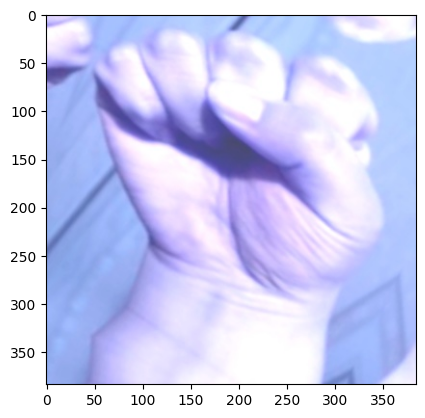

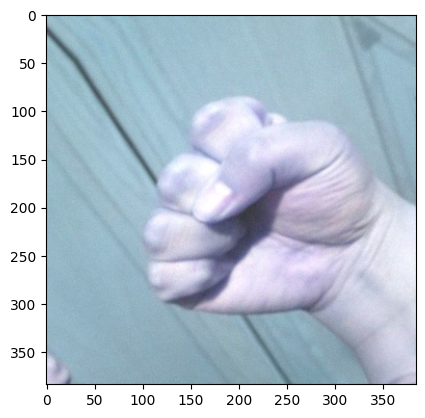

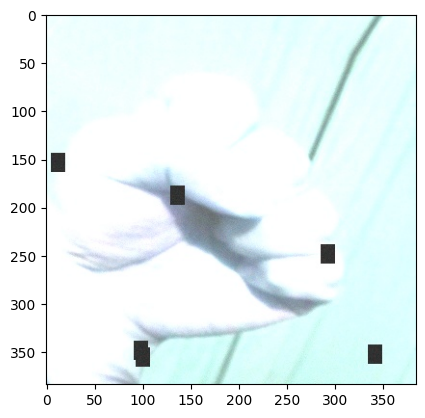

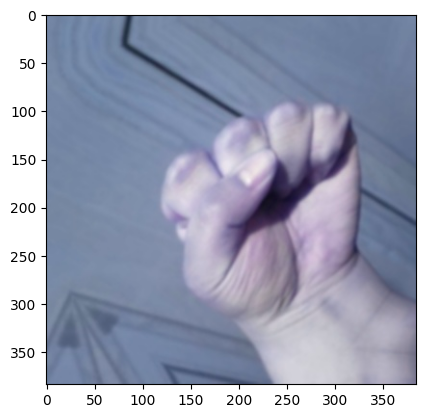

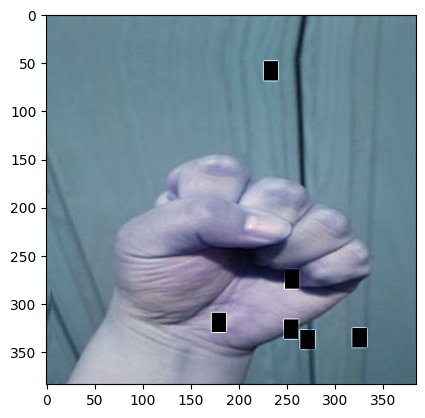

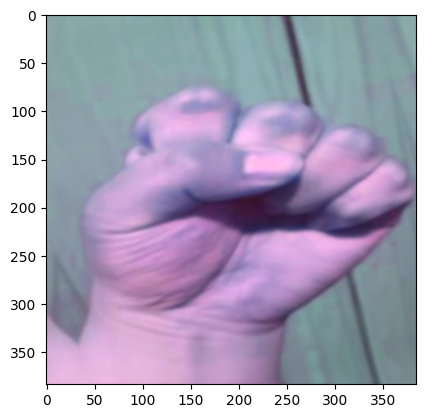

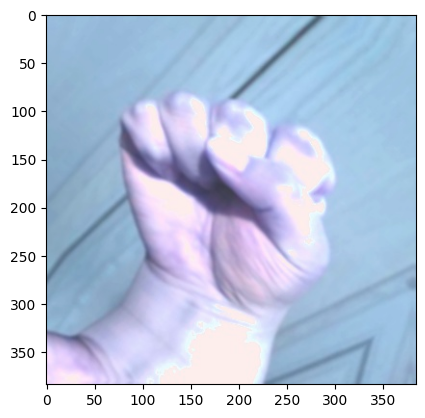

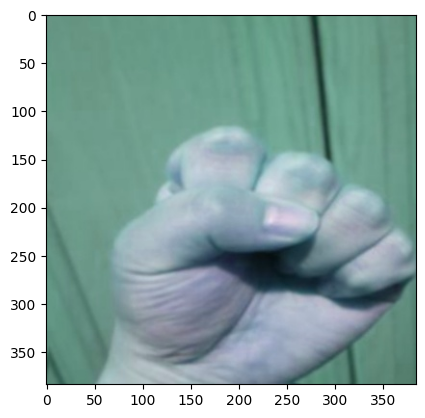

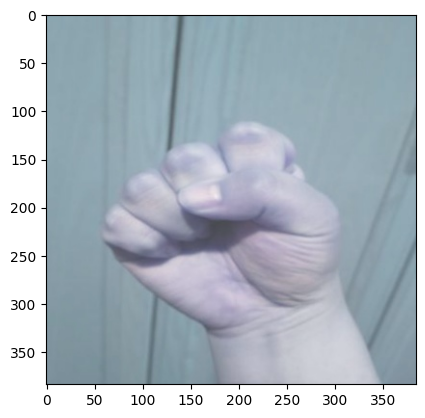

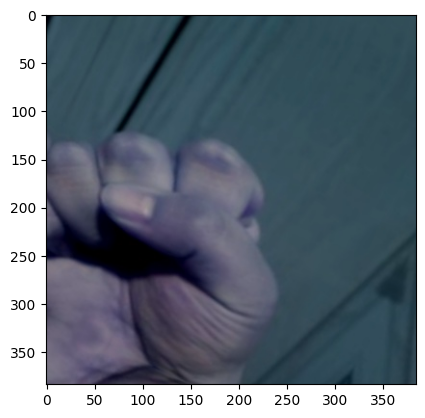

In [253]:
for i in range(10):
    test_aug_image = cv2.imread(
        f'{AUG_IMAGES_PATH}/S8_jpg.rf.a6fc375e5671f87b32ca0d691750a310_aug_{i}.jpg'
    )
    plt.imshow(test_aug_image)
    plt.show()

In [254]:
df = pd.read_csv(f'{DATASET_PATH}/annotations.csv')
df.head()

,image_id,bbox
0,S8_jpg.rf.a6fc375e5671f87b32ca0d691750a310_aug...,"[18, 0.5, 0.5, 1.0, 1.0]"
1,S8_jpg.rf.a6fc375e5671f87b32ca0d691750a310_aug...,"[18, 0.51171875, 0.5052083333333334, 0.9765625..."
2,S8_jpg.rf.a6fc375e5671f87b32ca0d691750a310_aug...,"[18, 0.5, 0.5, 1.0, 1.0]"
3,S8_jpg.rf.a6fc375e5671f87b32ca0d691750a310_aug...,"[18, 0.5, 0.5, 1.0, 1.0]"
4,S8_jpg.rf.a6fc375e5671f87b32ca0d691750a310_aug...,"[18, 0.52734375, 0.6354166666666666, 0.9140625..."


In [255]:
# Convert string to list
df.bbox = df.bbox.apply(ast.literal_eval)

In [256]:
new_bboxes = df['bbox'][0][1:]

In [257]:
new_bboxes

[0.5, 0.5, 1.0, 1.0]

In [258]:
bbox_cat = df['bbox'][0][0]
bbox_cat

18

In [259]:
# Converting bbox to pascal_voc format
x_min = int((384 * new_bboxes[0]) - ((new_bboxes[2] * 384) / 2))
x_max = int((384 * new_bboxes[0]) + ((new_bboxes[2] * 384) / 2))
y_min = int(384 * new_bboxes[1] - ((new_bboxes[3] * 384) / 2))
y_max = int(384 * new_bboxes[1] + ((new_bboxes[3] * 384) / 2))
new_bboxes = [x_min, y_min, x_max, y_max]

In [260]:
new_bboxes

[0, 0, 384, 384]

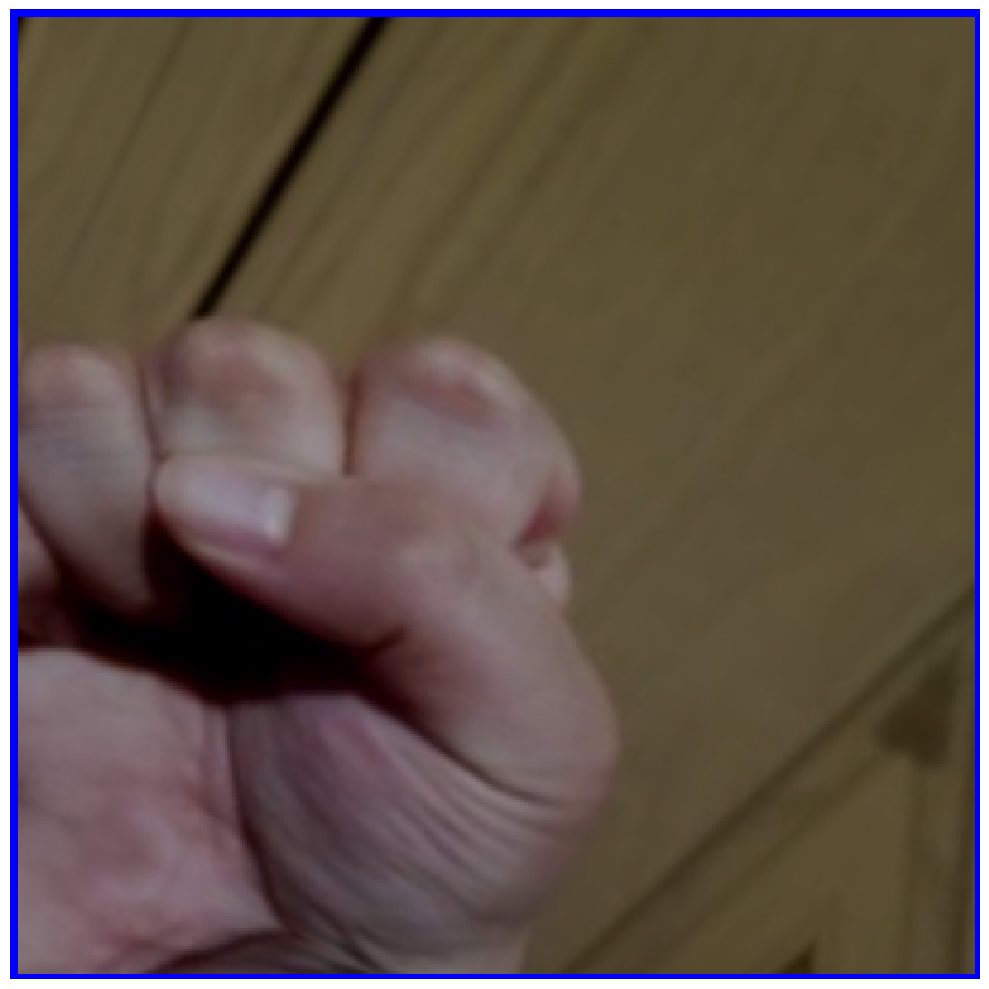

In [261]:
show_image(test_aug_image, new_bboxes, bbox_cat, category_id_to_name)